In [1]:
!apt install gdal-bin python-gdal python3-gdal 
# install rtree - geopandas requirement
!apt install python3-rtree 
# install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# install descartes - geopandas requirment
!pip install descartes 
# install vincenty module
!pip install vincenty
# install geo-py module
!pip install geopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-

In [2]:
from shapely.geometry import box, LineString, MultiLineString, Point, Polygon
from vincenty import vincenty

import datetime
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import os
import pandas as pd
import sys

plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


####**functions**

In [4]:
def merge_series_df(df, series_list, col_rename):
  for i in range(len(series_list)):
    df_series = pd.Series(series_list[i])
    df = pd.concat([df, df_series], axis = 1, sort= False)
    df = df.rename(columns= {0 : col_rename[i]})

  return df

In [5]:
def calc_gps_features(df):
  # create lists for distance, acceleration, jerk
  distance = []
  acceleration = []
  jerk = []
  
  for idx, row in df.iterrows():
    # create Points
    p1 = (row[0], row[1])
    p2 = (row[2], row[3])
    p3 = (row[4], row[5])
    p4 = (row[6], row[7])
  
    dist1 = vincenty(p1, p2)
    dist2 = vincenty(p2, p3)
    dist3 = vincenty(p3, p4)

    distance.append(dist1)

    dt1 = (row[9] - row[8]).total_seconds()
    dt2 = (row[10] - row[9]).total_seconds()
    dt3 = (row[11] - row[10]).total_seconds()

    if dt1 == 0:
      velocity1 = 0
    else:
      velocity1 = dist1/dt1

    # velocity.append(velocity1)

    if dt2 == 0:
      velocity2 = 0
    else:
      velocity2 = dist2/dt2
    
    if dt3 == 0:
      velocity3 = 0
    else:
      velocity3 = dist3/dt3

    if dt1 == 0:
      acceleration1 = 0
    else:
      acceleration1 = (velocity2 - velocity1) / dt1

    acceleration.append(acceleration1)
      
    if dt2 == 0:
      acceleration2 = 0
    else:
      acceleration2 = (velocity3 - velocity2) / dt2

    if dt1 == 0:
      jerk1 = 0
    else:
      jerk1 = (acceleration2 - acceleration1) / dt1

    jerk.append(jerk1)
  
  return distance, acceleration, jerk

In [6]:
# source : https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/
# source : https://www.igismap.com/map-tool/bearing-angle
# source : https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html

def calc_bearing(lat1, lon1, lat2, lon2, lat3, lon3):
  x1 = (np.cos(lat1) * np.sin(lat2)) - (np.sin(lat1) * np.cos(lat2) * np.cos(lon2 - lon1))
  y1 = np.sin(lon2 - lon1) * np.cos(lat2)
  b1 = np.arctan2(x1, y1)

  x2 = (np.cos(lat2) * np.sin(lat3)) - (np.sin(lat2) * np.cos(lat3) * np.cos(lon3 - lon2))
  y2 = np.sin(lon3 - lon2) * np.cos(lat3)
  b2 = np.arctan2(x2, y2)

  bearing = np.abs(b1 - b2)
  
  return bearing

In [7]:
def calc_distance(df):
  d1 = []
  d2 = []
  d3 = []
  for idx, row in df.iterrows():
    # create Points
    p1 = (row[0], row[1])
    p2 = (row[2], row[3])
    p3 = (row[4], row[5])
    p4 = (row[6], row[7])
    # calculate distance  
    dist1 = vincenty(p1, p2)
    dist2 = vincenty(p2, p3)
    dist3 = vincenty(p3, p4)

    d1.append(dist1)
    d2.append(dist2)
    d3.append(dist3)

  return d1, d2, d3


####**mtl_pts**

In [8]:
# change directory
drive.mount('/content/drive', force_remount= True)
os.chdir('/content/drive/My Drive/MRP/to_be_submitted')

Mounted at /content/drive


In [9]:
# this file has been joined with DAUID/CTUID geo ids using qgis
mtl_pts_json = 'mtl_pts_2017_SMT_geo_id_MRP.geojson'

In [10]:
# import file
mtl_pts = gpd.read_file(mtl_pts_json)
mtl_pts.head()

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry
0,45.546167,-73.646082,8.31,37.781403,2017-09-18T10:03:52,150744,0,10761,24660491,4620266.00,MULTIPOINT (-73.64608 45.54617)
1,45.545952,-73.645344,13.60,38.696411,2017-09-18T10:03:57,150744,1,10761,24660491,4620266.00,MULTIPOINT (-73.64534 45.54595)
2,45.545662,-73.644330,14.79,39.560181,2017-09-18T10:04:03,150744,2,10761,24660491,4620266.00,MULTIPOINT (-73.64433 45.54566)
3,45.545451,-73.643589,11.87,39.500397,2017-09-18T10:04:08,150744,3,10761,24660491,4620266.00,MULTIPOINT (-73.64359 45.54545)
4,45.545226,-73.642798,11.63,40.618835,2017-09-18T10:04:15,150744,4,10761,24660491,4620266.00,MULTIPOINT (-73.64280 45.54523)


In [11]:
# get max value for id_trip_seq
max_seq_id = mtl_pts[['id_trip', 'id_trip_seq']].groupby('id_trip')['id_trip_seq'].max().reset_index(name = 'num_coords')
# add 1 to num_coords
max_seq_id['num_coords'] = max_seq_id['num_coords'] + 1
max_seq_id.head()

,id_trip,num_coords
0,7,33
1,13,2
2,21,15
3,22,90
4,27,90


In [12]:
# as per Yazdizadeh et al. remove trips with less than 10 GPS coordinates 
# (removing anything with less than 15 as 4 GPS coordinates are required to calc. bearing and 5 GPS pts will be used for smoothing)
print ('no. of trips : {}'.format(len(mtl_pts['id_trip'].unique())))

remove_id_trip = max_seq_id['id_trip'][max_seq_id['num_coords'] < 15].reset_index(drop = True)
print ('no. of trips with less than 10 gps coords : {}\n'.format(len(remove_id_trip)))

# remove trips
mtl_pts = mtl_pts[~mtl_pts['id_trip'].isin(remove_id_trip)]
print ('no. of trips (revised): {}'.format(len(mtl_pts['id_trip'].unique())))

no. of trips : 61299
no. of trips with less than 10 gps coords : 14207

no. of trips (revised): 47092


In [13]:
# find trips where qgis was not able to find an intersection point with the first gps coord of each trip
print ('no. of trips : {}'.format(len(mtl_pts['id_trip'].unique())))

match_qgis_id = mtl_pts['id_trip'][mtl_pts['id_trip_seq'] == 0].reset_index(drop = True)
no_match_qgis = len(mtl_pts['id_trip'].unique()) - len(match_qgis_id)
print ('no. of trips (no match) : {}'.format(no_match_qgis))

mtl_pts = mtl_pts[mtl_pts['id_trip'].isin(match_qgis_id)]
print ('no. of trips (revised): {}'.format(len(mtl_pts['id_trip'].unique())))

no. of trips : 47092
no. of trips (no match) : 40
no. of trips (revised): 47052


In [14]:
# convert timestamp to datetime
mtl_pts['timestamp'] = pd.to_datetime(mtl_pts['timestamp'])

In [15]:
# https://towardsdatascience.com/a-gentle-introduction-to-iot-gps-trajectory-clustering-and-geospatial-clustering-daba8da8c41e
# add some initial shifts
mtl_pts['lat_shift'] = mtl_pts['latitude'].shift(-1)
mtl_pts['lon_shift'] = mtl_pts['longitude'].shift(-1)
mtl_pts['time_shift'] = mtl_pts['timestamp'].shift(-1)
mtl_pts['speed_shift'] = mtl_pts['speed'].shift(-1)

mtl_pts['lat_shift2'] = mtl_pts['latitude'].shift(-2)
mtl_pts['lon_shift2'] = mtl_pts['longitude'].shift(-2)
mtl_pts['time_shift2'] = mtl_pts['timestamp'].shift(-2)
mtl_pts['speed_shift2'] = mtl_pts['speed'].shift(-2)

mtl_pts['lat_shift3'] = mtl_pts['latitude'].shift(-3)
mtl_pts['lon_shift3'] = mtl_pts['longitude'].shift(-3)
mtl_pts['time_shift3'] = mtl_pts['timestamp'].shift(-3)
mtl_pts['speed_shift3'] = mtl_pts['speed'].shift(-3)

mtl_pts.head()

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry,lat_shift,lon_shift,time_shift,speed_shift,lat_shift2,lon_shift2,time_shift2,speed_shift2,lat_shift3,lon_shift3,time_shift3,speed_shift3
0,45.546167,-73.646082,8.31,37.781403,2017-09-18 10:03:52,150744,0,10761,24660491,4620266.00,MULTIPOINT (-73.64608 45.54617),45.545952,-73.645344,2017-09-18 10:03:57,13.60,45.545662,-73.644330,2017-09-18 10:04:03,14.79,45.545451,-73.643589,2017-09-18 10:04:08,11.87
1,45.545952,-73.645344,13.60,38.696411,2017-09-18 10:03:57,150744,1,10761,24660491,4620266.00,MULTIPOINT (-73.64534 45.54595),45.545662,-73.644330,2017-09-18 10:04:03,14.79,45.545451,-73.643589,2017-09-18 10:04:08,11.87,45.545226,-73.642798,2017-09-18 10:04:15,11.63
2,45.545662,-73.644330,14.79,39.560181,2017-09-18 10:04:03,150744,2,10761,24660491,4620266.00,MULTIPOINT (-73.64433 45.54566),45.545451,-73.643589,2017-09-18 10:04:08,11.87,45.545226,-73.642798,2017-09-18 10:04:15,11.63,45.545046,-73.642166,2017-09-18 10:04:19,12.86
3,45.545451,-73.643589,11.87,39.500397,2017-09-18 10:04:08,150744,3,10761,24660491,4620266.00,MULTIPOINT (-73.64359 45.54545),45.545226,-73.642798,2017-09-18 10:04:15,11.63,45.545046,-73.642166,2017-09-18 10:04:19,12.86,45.544861,-73.641528,2017-09-18 10:04:23,12.75
4,45.545226,-73.642798,11.63,40.618835,2017-09-18 10:04:15,150744,4,10761,24660491,4620266.00,MULTIPOINT (-73.64280 45.54523),45.545046,-73.642166,2017-09-18 10:04:19,12.86,45.544861,-73.641528,2017-09-18 10:04:23,12.75,45.544633,-73.640747,2017-09-18 10:04:29,10.51


In [16]:
# given that we are going to use 75 GPS datapoints for each trip seq remove any seq_id with more than 80 GPS coordinates
# additional coordinates used for other calculations
mtl_pts = mtl_pts[mtl_pts['id_trip_seq'] < 80]
mtl_pts = mtl_pts.reset_index(drop = True)

In [17]:
# query trips with less than 80 GPS coordinates 
short_trips = mtl_pts[['id_trip', 'id_trip_seq']].groupby('id_trip')['id_trip_seq'].max().reset_index(name = 'max_seq')
short_trips = short_trips[short_trips['max_seq'] < 79]
# a min. of 4 GPS coords required to calculate bearing rate
short_trips['keep_seq'] = short_trips['max_seq'] - 3
short_trips['keep_seq'] = np.where(short_trips['keep_seq'] < 0, -1, short_trips['keep_seq'])

print('total no. of trips : {}'.format(len(mtl_pts['id_trip'].unique())))
print('no. of trips with less than 80 GPS coords : {}'.format(len(short_trips)))

short_trips.head()

total no. of trips : 47052
no. of trips with less than 80 GPS coords : 27237


,id_trip,max_seq,keep_seq
0,7,32,29
1,21,14,11
6,68,24,21
7,79,35,32
9,102,63,60


In [18]:
# merge short_trips with mtl_pts in order to clean shifted data
mtl_pts = mtl_pts.merge(short_trips, how = 'left', on = 'id_trip')
mtl_pts.tail()

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry,lat_shift,lon_shift,time_shift,speed_shift,lat_shift2,lon_shift2,time_shift2,speed_shift2,lat_shift3,lon_shift3,time_shift3,speed_shift3,max_seq,keep_seq
2661779,45.548738,-73.591778,8.08,73.022339,2017-10-18 03:38:19,359384,15,10761,24661659,4620206.00,MULTIPOINT (-73.59178 45.54874),45.548520,-73.591948,2017-10-18 03:38:23,6.79,45.548324,-73.592120,2017-10-18 03:38:30,3.46,45.548088,-73.592318,2017-10-18 03:38:34,7.37,19.0,16.0
2661780,45.548520,-73.591948,6.79,73.138794,2017-10-18 03:38:23,359384,16,10761,24661975,4620205.00,MULTIPOINT (-73.59195 45.54852),45.548324,-73.592120,2017-10-18 03:38:30,3.46,45.548088,-73.592318,2017-10-18 03:38:34,7.37,45.547688,-73.592651,2017-10-18 03:38:40,8.60,19.0,16.0
2661781,45.548324,-73.592120,3.46,71.443604,2017-10-18 03:38:30,359384,17,10761,24661975,4620205.00,MULTIPOINT (-73.59212 45.54832),45.548088,-73.592318,2017-10-18 03:38:34,7.37,45.547688,-73.592651,2017-10-18 03:38:40,8.60,NaN,NaN,NaT,NaN,19.0,16.0
2661782,45.548088,-73.592318,7.37,71.399292,2017-10-18 03:38:34,359384,18,10761,24661974,4620205.00,MULTIPOINT (-73.59232 45.54809),45.547688,-73.592651,2017-10-18 03:38:40,8.60,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,19.0,16.0
2661783,45.547688,-73.592651,8.60,71.154114,2017-10-18 03:38:40,359384,19,10761,24661974,4620205.00,MULTIPOINT (-73.59265 45.54769),NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,19.0,16.0


In [19]:
mtl_pts[mtl_pts['id_trip'] == 21]

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry,lat_shift,lon_shift,time_shift,speed_shift,lat_shift2,lon_shift2,time_shift2,speed_shift2,lat_shift3,lon_shift3,time_shift3,speed_shift3,max_seq,keep_seq
243480,45.550466,-73.640386,1.67,36.294342,2017-09-25 22:07:48,21,0,10761,24662614,4620265.00,MULTIPOINT (-73.64039 45.55047),45.550245,-73.640489,2017-09-25 22:08:06,1.43,45.550030,-73.640594,2017-09-25 22:08:24,1.40,45.549826,-73.640441,2017-09-25 22:08:46,1.53,14.0,11.0
243481,45.550245,-73.640489,1.43,36.758759,2017-09-25 22:08:06,21,1,10761,24662614,4620265.00,MULTIPOINT (-73.64049 45.55024),45.550030,-73.640594,2017-09-25 22:08:24,1.40,45.549826,-73.640441,2017-09-25 22:08:46,1.53,45.549756,-73.640120,2017-09-25 22:09:03,1.44,14.0,11.0
243482,45.550030,-73.640594,1.40,37.182159,2017-09-25 22:08:24,21,2,10761,24662614,4620265.00,MULTIPOINT (-73.64059 45.55003),45.549826,-73.640441,2017-09-25 22:08:46,1.53,45.549756,-73.640120,2017-09-25 22:09:03,1.44,45.549657,-73.639821,2017-09-25 22:09:20,1.73,14.0,11.0
243483,45.549826,-73.640441,1.53,36.781860,2017-09-25 22:08:46,21,3,10761,24662604,4620265.00,MULTIPOINT (-73.64044 45.54983),45.549756,-73.640120,2017-09-25 22:09:03,1.44,45.549657,-73.639821,2017-09-25 22:09:20,1.73,45.549581,-73.639515,2017-09-25 22:09:38,1.34,14.0,11.0
243484,45.549756,-73.640120,1.44,37.739563,2017-09-25 22:09:03,21,4,10761,24662604,4620265.00,MULTIPOINT (-73.64012 45.54976),45.549657,-73.639821,2017-09-25 22:09:20,1.73,45.549581,-73.639515,2017-09-25 22:09:38,1.34,45.549413,-73.639294,2017-09-25 22:09:53,1.37,14.0,11.0
243485,45.549657,-73.639821,1.73,37.880432,2017-09-25 22:09:20,21,5,10761,24662604,4620265.00,MULTIPOINT (-73.63982 45.54966),45.549581,-73.639515,2017-09-25 22:09:38,1.34,45.549413,-73.639294,2017-09-25 22:09:53,1.37,45.549192,-73.639385,2017-09-25 22:10:08,1.69,14.0,11.0
243486,45.549581,-73.639515,1.34,37.291077,2017-09-25 22:09:38,21,6,10761,24662604,4620265.00,MULTIPOINT (-73.63952 45.54958),45.549413,-73.639294,2017-09-25 22:09:53,1.37,45.549192,-73.639385,2017-09-25 22:10:08,1.69,45.549026,-73.639167,2017-09-25 22:10:27,1.51,14.0,11.0
243487,45.549413,-73.639294,1.37,37.313904,2017-09-25 22:09:53,21,7,10761,24662604,4620265.00,MULTIPOINT (-73.63929 45.54941),45.549192,-73.639385,2017-09-25 22:10:08,1.69,45.549026,-73.639167,2017-09-25 22:10:27,1.51,45.548863,-73.638938,2017-09-25 22:10:44,1.68,14.0,11.0
243488,45.549192,-73.639385,1.69,36.780914,2017-09-25 22:10:08,21,8,10761,24662604,4620265.00,MULTIPOINT (-73.63939 45.54919),45.549026,-73.639167,2017-09-25 22:10:27,1.51,45.548863,-73.638938,2017-09-25 22:10:44,1.68,45.548732,-73.638674,2017-09-25 22:11:02,1.39,14.0,11.0
243489,45.549026,-73.639167,1.51,38.660400,2017-09-25 22:10:27,21,9,10761,24662604,4620265.00,MULTIPOINT (-73.63917 45.54903),45.548863,-73.638938,2017-09-25 22:10:44,1.68,45.548732,-73.638674,2017-09-25 22:11:02,1.39,45.548502,-73.638697,2017-09-25 22:11:20,1.30,14.0,11.0


In [20]:
print ('no. of trips where max len = 80 : {}'.format(len(mtl_pts['id_trip'][mtl_pts['max_seq'].isna() == True].unique())))
# fill nan values within max_seq to 79 (complete trip records)
mtl_pts['max_seq'] = mtl_pts['max_seq'].fillna(79)
mtl_pts['keep_seq'] = mtl_pts['keep_seq'].fillna(79)
print ('no. of trips where max len = 80 : {}'.format(len(mtl_pts['id_trip'][mtl_pts['max_seq'] == 79].unique())))

no. of trips where max len = 80 : 19815
no. of trips where max len = 80 : 19815


(array([5286., 3767., 3608., 2713., 2296., 2550., 1762., 1898., 1512.,
        1845.]),
 array([14. , 20.4, 26.8, 33.2, 39.6, 46. , 52.4, 58.8, 65.2, 71.6, 78. ]),
 <a list of 10 Patch objects>)

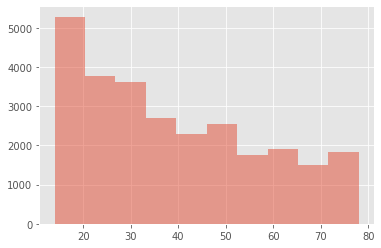

In [21]:
plt.hist(short_trips['max_seq'], alpha = 0.5)

In [22]:
# create boolean filter to determine which records to keep
mtl_pts['keep_record'] = np.where(mtl_pts['id_trip_seq'] <= mtl_pts['keep_seq'], 1, 0)
mtl_pts.tail()

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry,lat_shift,lon_shift,time_shift,speed_shift,lat_shift2,lon_shift2,time_shift2,speed_shift2,lat_shift3,lon_shift3,time_shift3,speed_shift3,max_seq,keep_seq,keep_record
2661779,45.548738,-73.591778,8.08,73.022339,2017-10-18 03:38:19,359384,15,10761,24661659,4620206.00,MULTIPOINT (-73.59178 45.54874),45.548520,-73.591948,2017-10-18 03:38:23,6.79,45.548324,-73.592120,2017-10-18 03:38:30,3.46,45.548088,-73.592318,2017-10-18 03:38:34,7.37,19.0,16.0,1
2661780,45.548520,-73.591948,6.79,73.138794,2017-10-18 03:38:23,359384,16,10761,24661975,4620205.00,MULTIPOINT (-73.59195 45.54852),45.548324,-73.592120,2017-10-18 03:38:30,3.46,45.548088,-73.592318,2017-10-18 03:38:34,7.37,45.547688,-73.592651,2017-10-18 03:38:40,8.60,19.0,16.0,1
2661781,45.548324,-73.592120,3.46,71.443604,2017-10-18 03:38:30,359384,17,10761,24661975,4620205.00,MULTIPOINT (-73.59212 45.54832),45.548088,-73.592318,2017-10-18 03:38:34,7.37,45.547688,-73.592651,2017-10-18 03:38:40,8.60,NaN,NaN,NaT,NaN,19.0,16.0,0
2661782,45.548088,-73.592318,7.37,71.399292,2017-10-18 03:38:34,359384,18,10761,24661974,4620205.00,MULTIPOINT (-73.59232 45.54809),45.547688,-73.592651,2017-10-18 03:38:40,8.60,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,19.0,16.0,0
2661783,45.547688,-73.592651,8.60,71.154114,2017-10-18 03:38:40,359384,19,10761,24661974,4620205.00,MULTIPOINT (-73.59265 45.54769),NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,19.0,16.0,0


In [23]:
# remove records
mtl_pts = mtl_pts[mtl_pts['keep_record'] == 1]
mtl_pts = mtl_pts.reset_index(drop = True)
print ('no. of records : {}'.format(len(mtl_pts)) )

no. of records : 2580174


In [24]:
# calculate time difference in seconds
mtl_pts['total_duration_secs'] = (mtl_pts['time_shift'] - mtl_pts['timestamp']).dt.total_seconds()

# there should be no records where total_seconds = 0
print ('no. of GPS coords where total_seconds = 0 : {}'.format(len(mtl_pts['total_duration_secs'][mtl_pts['total_duration_secs'] == 0])))

no. of GPS coords where total_seconds = 0 : 645


In [25]:
# query records where total_seconds = 0
mtl_pts[mtl_pts['total_duration_secs'] == 0].head()

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry,lat_shift,lon_shift,time_shift,speed_shift,lat_shift2,lon_shift2,time_shift2,speed_shift2,lat_shift3,lon_shift3,time_shift3,speed_shift3,max_seq,keep_seq,keep_record,total_duration_secs
47078,45.520268,-73.556632,0.000000,NaN,2017-09-20 11:50:55,383412,17,10761,24661863,4620045.00,MULTIPOINT (-73.55663 45.52027),45.518310,-73.558574,2017-09-20 11:50:55,4.14,45.518208,-73.558718,2017-09-20 11:51:08,1.004042,45.518176,-73.559164,2017-09-20 11:51:19,4.170000,50.0,47.0,1,0.0
50690,45.528085,-73.556810,0.000000,NaN,2017-09-20 12:36:59,41555,32,10761,24663333,4620037.00,MULTIPOINT (-73.55681 45.52809),45.528331,-73.557204,2017-09-20 12:36:59,0.00,45.528333,-73.557205,2017-09-20 12:37:17,0.000000,45.527956,-73.556833,2017-09-20 12:37:26,0.000000,79.0,79.0,1,0.0
57804,45.506751,-73.684229,0.000000,NaN,2017-09-20 17:01:52,23889,18,51157,24660585,4620412.00,MULTIPOINT (-73.68423 45.50675),45.504055,-73.676633,2017-09-20 17:01:52,16.00,45.503827,-73.676115,2017-09-20 17:01:55,16.000000,45.503629,-73.675577,2017-09-20 17:01:58,15.750000,79.0,79.0,1,0.0
57814,45.503223,-73.670511,17.000000,NaN,2017-09-20 17:02:21,23889,28,51157,24660595,4620412.00,MULTIPOINT (-73.67051 45.50322),45.505078,-73.679645,2017-09-20 17:02:21,0.00,45.503275,-73.670105,2017-09-20 17:02:23,15.500000,45.503317,-73.669573,2017-09-20 17:02:26,13.000000,79.0,79.0,1,0.0
60556,45.543417,-73.591726,7.693977,NaN,2017-09-20 21:16:29,28088,51,10761,24662097,4620208.00,MULTIPOINT (-73.59173 45.54342),45.545512,-73.590090,2017-09-20 21:16:29,0.00,45.543147,-73.591977,2017-09-20 21:16:34,6.350246,45.542870,-73.592237,2017-09-20 21:16:39,7.796794,61.0,58.0,1,0.0


In [26]:
# quick check
mtl_pts.loc[47078:47079]

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry,lat_shift,lon_shift,time_shift,speed_shift,lat_shift2,lon_shift2,time_shift2,speed_shift2,lat_shift3,lon_shift3,time_shift3,speed_shift3,max_seq,keep_seq,keep_record,total_duration_secs
47078,45.520268,-73.556632,0.00,NaN,2017-09-20 11:50:55,383412,17,10761,24661863,4620045.00,MULTIPOINT (-73.55663 45.52027),45.518310,-73.558574,2017-09-20 11:50:55,4.140000,45.518208,-73.558718,2017-09-20 11:51:08,1.004042,45.518176,-73.559164,2017-09-20 11:51:19,4.17,50.0,47.0,1,0.0
47079,45.518310,-73.558574,4.14,NaN,2017-09-20 11:50:55,383412,18,10761,24661855,4620044.00,MULTIPOINT (-73.55857 45.51831),45.518208,-73.558718,2017-09-20 11:51:08,1.004042,45.518176,-73.559164,2017-09-20 11:51:19,4.170000,45.517908,-73.559298,2017-09-20 11:51:26,3.85,50.0,47.0,1,13.0


In [27]:
# quick check
mtl_pts.loc[50690:50691]

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry,lat_shift,lon_shift,time_shift,speed_shift,lat_shift2,lon_shift2,time_shift2,speed_shift2,lat_shift3,lon_shift3,time_shift3,speed_shift3,max_seq,keep_seq,keep_record,total_duration_secs
50690,45.528085,-73.556810,0.0,NaN,2017-09-20 12:36:59,41555,32,10761,24663333,4620037.00,MULTIPOINT (-73.55681 45.52809),45.528331,-73.557204,2017-09-20 12:36:59,0.0,45.528333,-73.557205,2017-09-20 12:37:17,0.0,45.527956,-73.556833,2017-09-20 12:37:26,0.0,79.0,79.0,1,0.0
50691,45.528331,-73.557204,0.0,NaN,2017-09-20 12:36:59,41555,33,10761,24661879,4620036.00,MULTIPOINT (-73.55720 45.52833),45.528333,-73.557205,2017-09-20 12:37:17,0.0,45.527956,-73.556833,2017-09-20 12:37:26,0.0,45.528334,-73.557205,2017-09-20 12:37:37,0.0,79.0,79.0,1,18.0


In [28]:
# query all id trips that contain at least one 0 second time duraction calc
zero_sec_trips = mtl_pts['id_trip'][mtl_pts['total_duration_secs'] == 0].unique()
print ('no. of trips that contain time duration (secs) = 0 : {}'.format(len(mtl_pts['id_trip'][mtl_pts['total_duration_secs'] == 0].unique())))

no. of trips that contain time duration (secs) = 0 : 484


In [29]:
print ('no. of unique trips : {}'.format(len(mtl_pts['id_trip'].unique())))
mtl_pts = mtl_pts[~mtl_pts['id_trip'].isin(zero_sec_trips)]
mtl_pts = mtl_pts.reset_index(drop = True)
print ('no. of unique trips (revised) : {}'.format(len(mtl_pts['id_trip'].unique())))

no. of unique trips : 47052
no. of unique trips (revised) : 46568


In [30]:
# double check for nan values before calculating gps features
check_cols = ['lat_shift', 'lon_shift', 'time_shift', 'speed_shift', 'lat_shift2', 'lon_shift2',	'speed_shift2', 'time_shift2', 
              'lat_shift3', 'lon_shift3', 'speed_shift3', 'time_shift3']

for col in check_cols:
  print ('{} : {} nan record(s)'.format(col, len(mtl_pts[mtl_pts[col].isna()])))

lat_shift : 0 nan record(s)
lon_shift : 0 nan record(s)
time_shift : 0 nan record(s)
speed_shift : 0 nan record(s)
lat_shift2 : 0 nan record(s)
lon_shift2 : 0 nan record(s)
speed_shift2 : 0 nan record(s)
time_shift2 : 0 nan record(s)
lat_shift3 : 0 nan record(s)
lon_shift3 : 0 nan record(s)
speed_shift3 : 0 nan record(s)
time_shift3 : 0 nan record(s)


In [31]:
distance, acceleration, jerk = calc_gps_features(mtl_pts[['latitude', 'longitude', 'lat_shift', 'lon_shift', 'lat_shift2', 'lon_shift2', 
                                                          'lat_shift3', 'lon_shift3', 'timestamp', 'time_shift', 'time_shift2', 'time_shift3']])

print ('distance [:5]\n{}'.format(distance[:5]))
print ('acceleration [:5]\n{}'.format(acceleration[:5]))
print ('jerk [:5]\n{}'.format(jerk[:5]))

distance [:5]
[0.062391, 0.085496, 0.06244, 0.066643, 0.053257]
acceleration [:5]
[0.0003542266666666669, -0.0002935555555555556, -0.0005935142857142861, 0.0005419744897959185, 4.024999999999992e-05]
jerk [:5]
[-0.00012955644444444448, -4.9993121693121746e-05, 0.00022709775510204095, -7.167492711370265e-05, -0.00016426562500000002]


In [ ]:
bearing = calc_bearing(mtl_pts['latitude'], mtl_pts['longitude'], mtl_pts['lat_shift'], mtl_pts['lon_shift'], 
                       mtl_pts['lat_shift2'], mtl_pts['lon_shift2'])

print ('bearing [:5]\n{}'.format(bearing[:5]))

bearing [:5]
0    0.001470
1    0.000854
2    0.000819
3    0.000596
4    0.000135
dtype: float64


In [ ]:
# convert to series before merging with mtl_pts
distance_series = pd.Series(distance)
acceleration_series = pd.Series(acceleration)
jerk_series = pd.Series(jerk)
bearing_series = pd.Series(bearing)

In [ ]:
# mtl_pts = mtl_pts.reset_index()
# del mtl_pts['index']

mtl_pts = pd.concat([mtl_pts, distance_series], axis= 1, sort= False)
mtl_pts = mtl_pts.rename(columns = {0:'distance'})

mtl_pts = pd.concat([mtl_pts, acceleration_series], axis= 1, sort= False)
mtl_pts = mtl_pts.rename(columns = {0:'acceleration'})

mtl_pts = pd.concat([mtl_pts, jerk_series], axis= 1, sort= False)
mtl_pts = mtl_pts.rename(columns = {0:'jerk'})

mtl_pts = pd.concat([mtl_pts, bearing_series], axis= 1, sort= False)
mtl_pts = mtl_pts.rename(columns = {0:'bearing'})

In [ ]:
mtl_pts.head()

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry,lat_shift,lon_shift,time_shift,speed_shift,lat_shift2,lon_shift2,time_shift2,speed_shift2,lat_shift3,lon_shift3,time_shift3,speed_shift3,max_seq,keep_seq,keep_record,total_duration_secs,distance,acceleration,jerk,bearing
0,45.546167,-73.646082,8.31,37.781403,2017-09-18 10:03:52,150744,0,10761,24660491,4620266.00,MULTIPOINT (-73.64608 45.54617),45.545952,-73.645344,2017-09-18 10:03:57,13.60,45.545662,-73.644330,2017-09-18 10:04:03,14.79,45.545451,-73.643589,2017-09-18 10:04:08,11.87,79.0,79.0,1,5.0,0.062391,0.000354,-0.000130,0.001470
1,45.545952,-73.645344,13.60,38.696411,2017-09-18 10:03:57,150744,1,10761,24660491,4620266.00,MULTIPOINT (-73.64534 45.54595),45.545662,-73.644330,2017-09-18 10:04:03,14.79,45.545451,-73.643589,2017-09-18 10:04:08,11.87,45.545226,-73.642798,2017-09-18 10:04:15,11.63,79.0,79.0,1,6.0,0.085496,-0.000294,-0.000050,0.000854
2,45.545662,-73.644330,14.79,39.560181,2017-09-18 10:04:03,150744,2,10761,24660491,4620266.00,MULTIPOINT (-73.64433 45.54566),45.545451,-73.643589,2017-09-18 10:04:08,11.87,45.545226,-73.642798,2017-09-18 10:04:15,11.63,45.545046,-73.642166,2017-09-18 10:04:19,12.86,79.0,79.0,1,5.0,0.062440,-0.000594,0.000227,0.000819
3,45.545451,-73.643589,11.87,39.500397,2017-09-18 10:04:08,150744,3,10761,24660491,4620266.00,MULTIPOINT (-73.64359 45.54545),45.545226,-73.642798,2017-09-18 10:04:15,11.63,45.545046,-73.642166,2017-09-18 10:04:19,12.86,45.544861,-73.641528,2017-09-18 10:04:23,12.75,79.0,79.0,1,7.0,0.066643,0.000542,-0.000072,0.000596
4,45.545226,-73.642798,11.63,40.618835,2017-09-18 10:04:15,150744,4,10761,24660491,4620266.00,MULTIPOINT (-73.64280 45.54523),45.545046,-73.642166,2017-09-18 10:04:19,12.86,45.544861,-73.641528,2017-09-18 10:04:23,12.75,45.544633,-73.640747,2017-09-18 10:04:29,10.51,79.0,79.0,1,4.0,0.053257,0.000040,-0.000164,0.000135


In [ ]:
# double check for nan values before calculating gps features
check_cols = ['distance', 'acceleration', 'jerk', 'bearing']

for col in check_cols:
  print ('{} : {} nan record(s)'.format(col, len(mtl_pts[mtl_pts[col].isna()])))

distance : 0 nan record(s)
acceleration : 0 nan record(s)
jerk : 0 nan record(s)
bearing : 0 nan record(s)


In [ ]:
mtl_pts[mtl_pts['jerk'].isna()].head()

,latitude,longitude,speed,altitude,timestamp,id_trip,id_trip_seq,weather_station_id,DAUID,CTUID,geometry,lat_shift,lon_shift,time_shift,speed_shift,lat_shift2,lon_shift2,time_shift2,speed_shift2,lat_shift3,lon_shift3,time_shift3,speed_shift3,max_seq,keep_seq,keep_record,total_duration_secs,distance,acceleration,jerk,bearing


In [ ]:
print ('no. of trips : {}'.format(len(mtl_pts['id_trip'].unique())))
print ('no. of records : {}\n'.format(len(mtl_pts)))

no. of trips : 46568
no. of records : 2550694



####**export file**

In [ ]:
# file for modelling purposes
mtl_pts_modelling = mtl_pts[['id_trip', 'id_trip_seq', 'geometry', 'timestamp', 'DAUID', 'CTUID', 'weather_station_id', 
                             'distance', 'speed', 'acceleration', 'jerk', 'bearing']]

print ('no. of trips : {}'.format(len(mtl_pts_modelling['id_trip'].unique())))

no. of trips : 46568


In [ ]:
mtl_pts_modelling.to_file('mtl_pts_2017_MODEL_MRP_NEW.geojson', driver = 'GeoJSON')

In [ ]:
mtl_pts.to_file('mtl_pts_2017_FINAL_MRP.geojson', driver = 'GeoJSON')